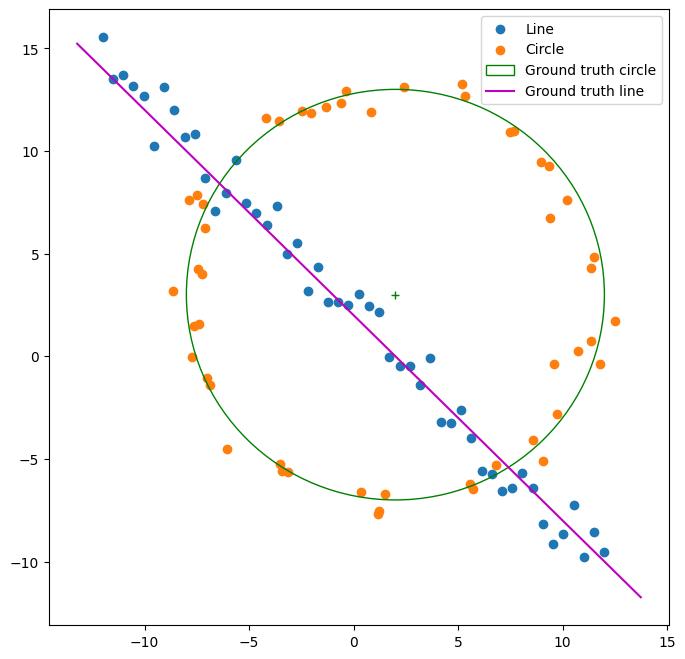

In [48]:
#RANSAC to fit a line and a circle to a data
from scipy.optimize import minimize
from scipy import linalg
import matplotlib.pyplot as plt
import numpy as np
#import tikzplotlib

N = 100
half_n = N//2
r = 10
x0_gt , y0_gt = 2,3
s = r/16
t = np.random.uniform(0,2*np.pi,half_n)
n = s * np.random.randn(half_n)
x, y = x0_gt + (r + n) * np.cos(t), y0_gt + (r + n) * np.sin(t)
X_circ = np.hstack((x.reshape(half_n, 1), y.reshape(half_n, 1)))

# Generate data for the line
s = 1.0
m, b = -1, 2
x = np.linspace(-12, 12, half_n)
y = m * x + b + s * np.random.randn(half_n)
X_line = np.hstack((x.reshape(half_n, 1), y.reshape(half_n, 1)))
# Combine circle and line data
X = np.vstack((X_circ, X_line))  # All points

# Create a scatter plot
fig, ax1 = plt.subplots(1, 1, figsize=(8, 8))
ax1.scatter(X_line[:, 0], X_line[:, 1], label='Line')
ax1.scatter(X_circ[:, 0], X_circ[:, 1], label='Circle')

# Add the ground truth circle
circle_gt = plt.Circle((x0_gt, y0_gt), r, color='g', fill=False, label='Ground truth circle')
ax1.add_patch(circle_gt)
ax1.plot(x0_gt, y0_gt, '+', color = 'g')
# Add the ground truth line
x_min, x_max = ax1.get_xlim()
x_ = np.array([x_min, x_max])
y_ = m * x_ + b
plt.plot(x_, y_, color='m', label='Ground truth line')

# Add legend
plt.legend()



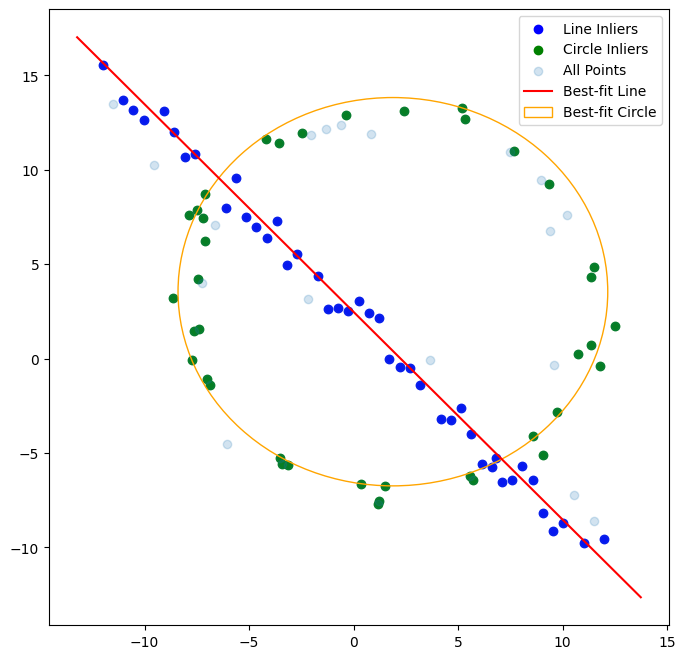

In [49]:
###################################################################################
# Function to calculate the line parameters [a, b, d] from two points
def fit_line(points):
    x1, y1 = points[0]
    x2, y2 = points[1]
    a = y2 - y1
    b = x1 - x2
    d = -(a * x1 + b * y1)
    return a, b, d

# RANSAC parameters for line fitting
max_iterations = 1000
min_inliers = 0.5 * len(X)
threshold = 0.9

best_line = None
best_inliers = []
best_inlier_count = 0

for _ in range(max_iterations):
    # Randomly sample two points from the data
    sample_indices = np.random.choice(len(X), 2, replace=False)
    sample_points = X[sample_indices]
    
    # Fit a line to the sample points
    a, b, d = fit_line(sample_points)
    
    # Calculate the distance from all points to the line
    distances = np.abs(a * X[:, 0] + b * X[:, 1] + d) / np.sqrt(a**2 + b**2)
    
    # Find inliers (points that are within the threshold)
    inliers = np.where(distances < threshold)[0]
    
    # Check if the current model has more inliers than the best model
    if len(inliers) > best_inlier_count:
        best_inlier_count = len(inliers)
        best_inliers = inliers
        best_line = (a, b, d)
    
    # Check for termination condition
    if len(inliers) > min_inliers:
        break

# Extract the best line parameters
best_a, best_b, best_d = best_line

# Plot the data points and the best-fit line
fig, ax = plt.subplots(1, 1, figsize=(8, 8))

# Subtract the consensus of the best line (remnant)
remnant_points = np.delete(X, best_inliers, axis=0)

# Function to calculate the circle parameters [x, y, r] from three points
def fit_circle(points):
    x1, y1 = points[0]
    x2, y2 = points[1]
    x3, y3 = points[2]
    
    D = 2 * (x1 * (y2 - y3) + x2 * (y3 - y1) + x3 * (y1 - y2))
    Ux = ((x1**2 + y1**2) * (y2 - y3) + (x2**2 + y2**2) * (y3 - y1) + (x3**2 + y3**2) * (y1 - y2)) / D
    Uy = ((x1**2 + y1**2) * (x3 - x2) + (x2**2 + y2**2) * (x1 - x3) + (x3**2 + y3**2) * (x2 - x1)) / D
    r = np.sqrt((x1 - Ux)**2 + (y1 - Uy)**2)
    
    return Ux, Uy, r

# RANSAC parameters for circle fitting
max_iterations_circle = 1000
min_inliers_circle = 20
threshold_circle = 1.0

best_circle = None
best_circle_inliers = []
best_circle_inlier_count = 0

for _ in range(max_iterations_circle):
    # Randomly sample three points from the remnant
    sample_indices_circle = np.random.choice(len(remnant_points), 3, replace=False)
    sample_points_circle = remnant_points[sample_indices_circle]
    
    # Fit a circle to the sample points
    x_circle, y_circle, r_circle = fit_circle(sample_points_circle)
    
    # Calculate the radial error from all points to the circle
    radial_errors = np.sqrt((remnant_points[:, 0] - x_circle)**2 + (remnant_points[:, 1] - y_circle)**2) - r_circle
    
    # Find inliers (points that are within the threshold)
    circle_inliers = np.where(np.abs(radial_errors) < threshold_circle)[0]
    
    # Check if the current model has more inliers than the best model
    if len(circle_inliers) > best_circle_inlier_count:
        best_circle_inlier_count = len(circle_inliers)
        best_circle_inliers = circle_inliers
        best_circle = (x_circle, y_circle, r_circle)
    
    # Check for termination condition
    if len(circle_inliers) > min_inliers_circle:
        break

# Extract the best circle parameters
best_x_circle, best_y_circle, best_r_circle = best_circle

# Plot the data points, the best-fit line, and the best-fit circle
ax.scatter(X[best_inliers, 0], X[best_inliers, 1], label='Line Inliers', color='blue')
ax.scatter(remnant_points[best_circle_inliers, 0], remnant_points[best_circle_inliers, 1], label='Circle Inliers', color='green')
ax.scatter(X[:, 0], X[:, 1], label='All Points', alpha=0.2)
x_min, x_max = ax.get_xlim()
x_values = np.array([x_min, x_max])
y_values = (-best_a / best_b) * x_values - (best_d / best_b)
ax.plot(x_values, y_values, color='r', label='Best-fit Line')

# Plot the best-fit circle
circle_fit = plt.Circle((best_x_circle, best_y_circle), best_r_circle, color='orange', fill=False, label='Best-fit Circle')
ax.add_patch(circle_fit)

plt.legend()
plt.show()




15.225779857166149 -11.741377000489129


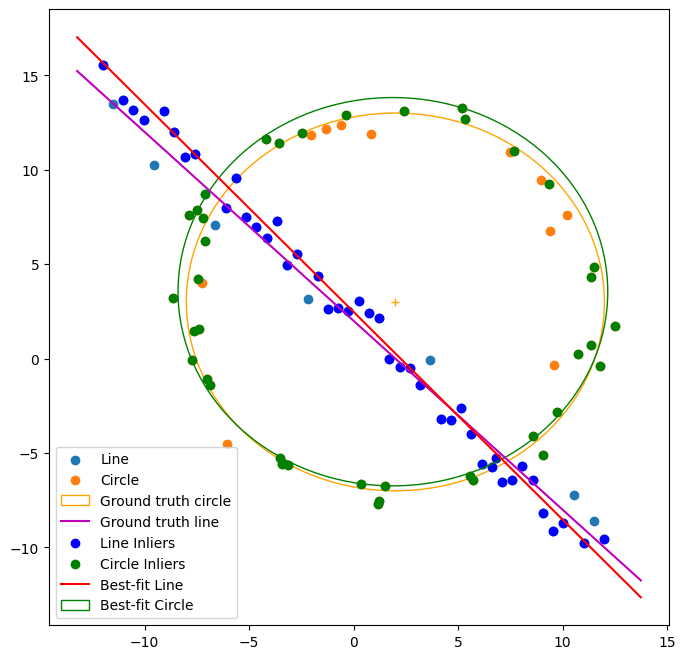

In [51]:
##### All three plots in one figure
fig, ax = plt.subplots(1, 1, figsize=(8, 8))

R = 10
x0_gt , y0_gt = 2,3
m, b = -1, 2

ax.scatter(X_line[:, 0], X_line[:, 1], label='Line')
ax.scatter(X_circ[:, 0], X_circ[:, 1], label='Circle')

# Add the ground truth circle
circle_gt = plt.Circle((x0_gt, y0_gt), R, color='orange', fill=False, label='Ground truth circle')
ax.add_patch(circle_gt)
ax.plot(x0_gt, y0_gt, '+', color = 'orange')
# Add the ground truth line
x_min, x_max = ax.get_xlim()
x_ = np.array([x_min, x_max])
y_ = m * x_ + b
print(max(y_), min(y_))
plt.plot(x_, y_, color='m', label='Ground truth line')

# Plot the data points and the best-fit line with ransac
ax.scatter(X[best_inliers, 0], X[best_inliers, 1], label='Line Inliers', color='blue')
ax.scatter(remnant_points[best_circle_inliers, 0], remnant_points[best_circle_inliers, 1], label='Circle Inliers', color='green')
# x_min, x_max = ax.get_xlim()
# x_values = np.array([x_min, x_max])
y_values = (-best_a / best_b) * x_values - (best_d / best_b)
ax.plot(x_values, y_values, color='r', label='Best-fit Line')

# Plot the best-fit circle with ransac
circle_fit = plt.Circle((best_x_circle, best_y_circle), best_r_circle, color='green', fill=False, label='Best-fit Circle')
ax.add_patch(circle_fit)

plt.legend()
plt.show()